### Capstone Work Notebook  
Adam Brenner

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [193]:
# Lets create a list of seasons to grab team data for from 2010 to 2018, the api takes the season years as
# 20102011 for the 2010 2011 season.
years = np.arange(2010, 2018)
years_list = []
for i in range(len(years)):
    years_list.append(str(years[i]) + str(years[i] + 1))

In [194]:
years_list

['20102011',
 '20112012',
 '20122013',
 '20132014',
 '20142015',
 '20152016',
 '20162017',
 '20172018']

In [4]:
# Calling the NHL API to grab season stats for all the teams that were active between 2010 to 2018
# We will be using the 20172018 season for checking our predictions.
team_data = []
for season in years_list:
    req = requests.get(url = 'http://statsapi.web.nhl.com/api/v1/standings?season={}'.format(season))
    for division in req.json()['records']:
        for team in division['teamRecords']:
            team_data.append({'team_name': team['team']['name'],
                             'team_id': team['team']['id'],
                             'season': season,
                             'points_percentage': team['pointsPercentage']})
            
team_id = set([team['team_id'] for team in team_data])

In [5]:
# We want to grab the players who were on a specific team for a specific season. Luckily the NHL API allows us to
# do just that fairly easily. Aggregating through the team ids and seasons to expand the roster for that year.
players_id = []
for team in team_id:
    for season in years_list:
        req = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/teams/{}/?expand=team.roster&season={}' \
                           .format(team, season))
        #print(req.status_code)
        try:
            for player in req.json()['teams'][0]['roster']['roster']:
                #print(player)
                players_id.append(player['person']['id'])
        except:
            pass

In [6]:
# Looking at the output for the player stats to decide what data we want to incorporate into the main gathering api
# request below.
req_player = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/people/{}'.format(players_id[0]))
print(req_player.json().keys())
print("\n", req_player.json()['people'][0])

dict_keys(['copyright', 'people'])

 {'id': 8458525, 'fullName': 'Brian Rolston', 'link': '/api/v1/people/8458525', 'firstName': 'Brian', 'lastName': 'Rolston', 'primaryNumber': '12', 'birthDate': '1973-02-21', 'birthCity': 'Flint', 'birthStateProvince': 'MI', 'birthCountry': 'USA', 'nationality': 'USA', 'height': '6\' 2"', 'weight': 215, 'active': False, 'rookie': False, 'shootsCatches': 'L', 'rosterStatus': 'Y', 'primaryPosition': {'code': 'R', 'name': 'Right Wing', 'type': 'Forward', 'abbreviation': 'RW'}}


In [7]:
# Looking at the output for player stats by season to see which stats we want to keep.
req_stats = requests.get('https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=yearByYear'.format(players_id[5625]))
print(req_stats.json().keys())
print(req_stats.json()['stats'][0]['splits'][12]['stat'])

dict_keys(['copyright', 'stats'])
{'timeOnIce': '1472:59', 'assists': 58, 'goals': 39, 'pim': 55, 'shots': 284, 'games': 74, 'hits': 38, 'powerPlayGoals': 12, 'powerPlayPoints': 32, 'powerPlayTimeOnIce': '267:00', 'evenTimeOnIce': '1183:20', 'penaltyMinutes': '55', 'faceOffPct': 41.92, 'shotPct': 13.73, 'gameWinningGoals': 12, 'overTimeGoals': 3, 'shortHandedGoals': 0, 'shortHandedPoints': 1, 'shortHandedTimeOnIce': '22:39', 'blocked': 22, 'plusMinus': 11, 'points': 97, 'shifts': 1760}


In [8]:
# Used for testing KeyErrors in the stats dictionary

# for i in players_id:
#     req_player = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/people/{}'.format(players_id[0]))
#     if req_player.json()['people'][0]['primaryPosition']['code'] != 'G':
#         req_stats = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=yearByYear'.format(i))
#         for season_stats in req_stats.json()['stats'][0]['splits']:
#             if season_stats['season'] in years_list and season_stats['league']['name'] == 'National Hockey League':
#                 try:
#                     print(i, season_stats['stat']['goals'])
#                 except KeyError:
#                     print('UNKNOWN')

In [9]:
# Now lets extract player stats for all the players that played between 2010 and 2018 using the player ids we gathered above.
# Notice we don't want to keep goalies for our stats as they very rarely accumulate points and have a different
# measurement of success than all other players.
player_stats = []
for i in players_id:
    req_player = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/people/{}'.format(i))
    if req_player.json()['people'][0]['primaryPosition']['code'] != 'G':
        player_data = {'name': req_player.json()['people'][0]['fullName'],
                      'position': req_player.json()['people'][0]['primaryPosition']['code'],
                      'country': req_player.json()['people'][0]['nationality'],
                      'birth_date': req_player.json()['people'][0]['birthDate'],
                      'id': i,
                      'height': req_player.json()['people'][0]['height'],
                      'weight': req_player.json()['people'][0]['weight'],
                      'shoots': req_player.json()['people'][0]['shootsCatches']}
        req_stats = requests.get(url = 'https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=yearByYear'.format(i))
        for season_stats in req_stats.json()['stats'][0]['splits']:
            if season_stats['season'] in years_list and season_stats['league']['name'] == 'National Hockey League':
                try:
                    player_data[season_stats['season']] = {season_stats['season']+'_goals': season_stats['stat']['goals'],
                                                          season_stats['season']+'_assists': season_stats['stat']['assists'],
                                                          season_stats['season']+'_shots': season_stats['stat']['shots'],
                                                          season_stats['season']+'_games': season_stats['stat']['games'],
                                                          season_stats['season']+'_time_on_ice': season_stats['stat']['timeOnIce'],
                                                          season_stats['season']+'_penalty_min': season_stats['stat']['pim'],
                                                          season_stats['season']+'_hits': season_stats['stat']['hits'],
                                                          season_stats['season']+'_shotPct': season_stats['stat']['shotPct'],
                                                          season_stats['season']+'_blocked': season_stats['stat']['blocked'],
                                                          season_stats['season']+'_plus_minus': season_stats['stat']['plusMinus'],
                                                          season_stats['season']+'_shifts': season_stats['stat']['shifts'],
                                                          season_stats['season']+'_total_points': season_stats['stat']['points'],
                                                          season_stats['season']+'_team': season_stats['team']['name']}
                except KeyError:
                    pass
        player_stats.append(player_data)

In [10]:
len(player_stats)

7648

In [11]:
# for stat in player_stats:
#     for season in years_list:
#         if season in stat.keys():
#             print(stat[season][season+'_games'])

In [12]:
# For accurate predictions lets get rid of any players that didn't play at least 2 seasons and 100 games.
# This will also limit the outliers, such as someone playing ten games and scoring 10 goals.
reduced_stats = []
for stat in player_stats:
    games = 0
    years = 0
    for season in years_list:
        if season in stat.keys():
            games += stat[season][season+'_games']
            years += 1
    if years >= 3 and games > 120:
        reduced_stats.append(stat)

In [13]:
len(reduced_stats)

5349

In [14]:
reduced_stats2 = reduced_stats

In [15]:
for stat in reduced_stats2:
    for season in years_list:
        if season not in stat.keys():
            stat[season] = {season+'_goals': 0,
                          season+'_assists': 0,
                          season+'_shots': 0,
                          season+'_games': 0,
                          season+'_time_on_ice': 0,
                          season+'_penalty_min': 0,
                          season+'_hits': 0,
                          season+'_shotPct': 0,
                          season+'_blocked': 0,
                          season+'_plus_minus': 0,
                          season+'_shifts': 0,
                          season+'_total_points': 0,
                          season+'_team': 'None'}

In [148]:
stats_DF = pd.DataFrame(reduced_stats)

In [149]:
# Since all the seasons stats are contained within each player as a dictionary. Lets split all these different season
# dictionaries into different columns such that 20102011_goals and 20172018_goals are seperate columns.
for c in stats_DF.columns[8:]:
    stats_DF = pd.concat([stats_DF.drop([c], axis = 1), stats_DF[c].apply(pd.Series)], axis = 1)

In [150]:
stats_DF.head()

,name,position,country,birth_date,id,height,weight,shoots,20102011_goals,20102011_assists,...,20172018_games,20172018_time_on_ice,20172018_penalty_min,20172018_hits,20172018_shotPct,20172018_blocked,20172018_plus_minus,20172018_shifts,20172018_total_points,20172018_team
0,Patrik Elias,C,CZE,1976-04-13,8460542,"6' 1""",190,L,21,41,...,0,0,0,0,0.0,0,0,0,0,None
1,Dainius Zubrus,C,LTU,1978-06-16,8464977,"6' 5""",225,L,13,17,...,0,0,0,0,0.0,0,0,0,0,None
2,Henrik Tallinder,D,SWE,1979-01-10,8466182,"6' 4""",209,L,5,11,...,0,0,0,0,0.0,0,0,0,0,None
3,Anton Volchenkov,D,RUS,1982-02-25,8468501,"6' 1""",220,L,0,8,...,0,0,0,0,0.0,0,0,0,0,None
4,Ilya Kovalchuk,L,RUS,1983-04-15,8469454,"6' 3""",222,R,31,29,...,0,0,0,0,0.0,0,0,0,0,None


In [151]:
stats_DF.shape

(5349, 112)

In [152]:
stats_DF.to_pickle("./stats_DF.pkl")

In [154]:
stats_DF = pd.read_pickle("./stats_DF.pkl")

In [155]:
for c in stats_DF.columns[8:]:
    if stats_DF[c].dtypes == object and c.find('team') == -1:
        stats_DF[c+'_min'] = pd.to_numeric(stats_DF[c].str.split(":", n = 1, expand = True)[0])
        stats_DF[c+'_sec'] = pd.to_numeric(stats_DF[c].str.split(":", n = 1, expand = True)[1])
        stats_DF = stats_DF.drop(columns = [c])

In [156]:
def height_transform(height):
    # Format = 6' 1"
    height = height.split("' ")
    feet = float(height[0])
    inch = float(height[1].replace("\"", ""))
    return(12 * feet) + inch

In [157]:
stats_DF['height'] = stats_DF['height'].apply(lambda x: height_transform(x))

In [158]:
for h in stats_DF['height'][0:10]:
    print(h)

73.0
77.0
76.0
73.0
75.0
78.0
71.0
72.0
74.0
76.0


In [159]:
for c in stats_DF.columns:
    print(c, "_____________", stats_DF[c].dtypes)

name _____________ object
position _____________ object
country _____________ object
birth_date _____________ object
id _____________ int64
height _____________ float64
weight _____________ int64
shoots _____________ object
20102011_goals _____________ int64
20102011_assists _____________ int64
20102011_shots _____________ int64
20102011_games _____________ int64
20102011_penalty_min _____________ int64
20102011_hits _____________ int64
20102011_shotPct _____________ float64
20102011_blocked _____________ int64
20102011_plus_minus _____________ int64
20102011_shifts _____________ int64
20102011_total_points _____________ int64
20102011_team _____________ object
20112012_goals _____________ int64
20112012_assists _____________ int64
20112012_shots _____________ int64
20112012_games _____________ int64
20112012_penalty_min _____________ int64
20112012_hits _____________ int64
20112012_shotPct _____________ float64
20112012_blocked _____________ int64
20112012_plus_minus _____________ int

In [160]:
drop_columns = []
for c in stats_DF.columns:
    if c.find('team') != -1:
        drop_columns.append(c)
    
drop_columns = ['name', 'birth_date', 'id'] + drop_columns

In [161]:
stats_DF = stats_DF.drop(columns = drop_columns)

In [162]:
stats_DF.fillna(value=0, inplace=True)

In [163]:
lec = LabelEncoder()

In [164]:
stats_DF['position'] = lec.fit_transform(stats_DF['position'])
stats_DF['country'] = lec.fit_transform(stats_DF['country'])
stats_DF['shoots'] = lec.fit_transform(stats_DF['shoots'])

In [165]:
with pd.option_context('display.max_rows', len(stats_DF)):
    print(stats_DF.isna().sum())

position                    0
country                     0
height                      0
weight                      0
shoots                      0
20102011_goals              0
20102011_assists            0
20102011_shots              0
20102011_games              0
20102011_penalty_min        0
20102011_hits               0
20102011_shotPct            0
20102011_blocked            0
20102011_plus_minus         0
20102011_shifts             0
20102011_total_points       0
20112012_goals              0
20112012_assists            0
20112012_shots              0
20112012_games              0
20112012_penalty_min        0
20112012_hits               0
20112012_shotPct            0
20112012_blocked            0
20112012_plus_minus         0
20112012_shifts             0
20112012_total_points       0
20122013_goals              0
20122013_assists            0
20122013_shots              0
20122013_games              0
20122013_penalty_min        0
20122013_hits               0
20122013_s

In [166]:
with pd.option_context('display.max_rows', len(stats_DF)):
    percentage_miss = (stats_DF.isna().sum() * 100) / len(stats_DF)
    missing_values_perc = pd.DataFrame({'Column Name': stats_DF.columns, 'Percent Missing': percentage_miss})
    print(missing_values_perc)

                                       Column Name  Percent Missing
position                                  position              0.0
country                                    country              0.0
height                                      height              0.0
weight                                      weight              0.0
shoots                                      shoots              0.0
20102011_goals                      20102011_goals              0.0
20102011_assists                  20102011_assists              0.0
20102011_shots                      20102011_shots              0.0
20102011_games                      20102011_games              0.0
20102011_penalty_min          20102011_penalty_min              0.0
20102011_hits                        20102011_hits              0.0
20102011_shotPct                  20102011_shotPct              0.0
20102011_blocked                  20102011_blocked              0.0
20102011_plus_minus            20102011_plus_min

In [167]:
drop_years = []
for c in stats_DF.columns[5:49]:
    drop_years.append(c)

In [168]:
stats_DF = stats_DF.drop(columns=drop_years)

In [169]:
drop_time = []
for c in stats_DF.columns[49:56]:
    drop_time.append(c)

In [170]:
stats_DF = stats_DF.drop(columns=drop_time)

In [171]:
# 5349 Rows by 109 Columns
stats_DF.shape

(5349, 58)

In [172]:
stats_DF.drop(stats_DF[(stats_DF['20152016_total_points'] == 0) | (stats_DF['20162017_total_points'] == 0) | \
                       (stats_DF['20172018_total_points'] == 0)].index, inplace = True)

In [173]:
stats_DF.shape

(3374, 58)

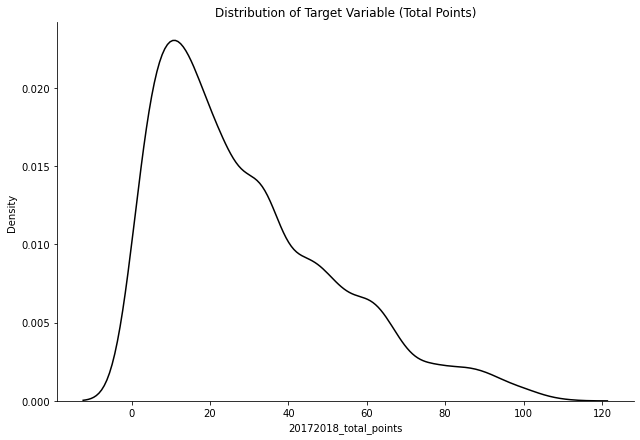

In [174]:
sns.displot(stats_DF, x = stats_DF['20172018_total_points'], kind = 'kde', height=6, aspect=1.5, color='black')
plt.title('Distribution of Target Variable (Total Points)')
plt.show()

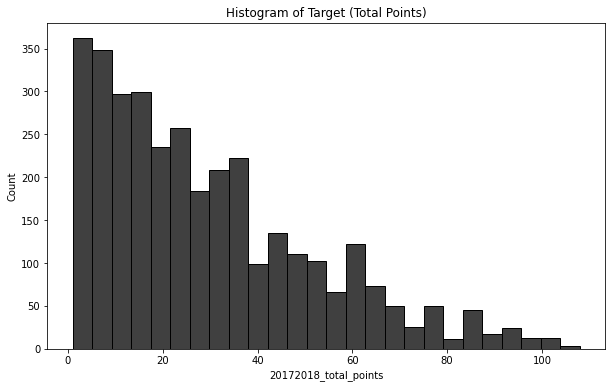

In [175]:
plt.figure(figsize=(10,6))
sns.histplot(stats_DF, x = '20172018_total_points', color='black')
plt.title('Histogram of Target (Total Points)')
plt.show()

The target variable, total points, is clearly heavily right skewed, so lets try a logarithmic and square root transformation.

<Figure size 720x432 with 0 Axes>

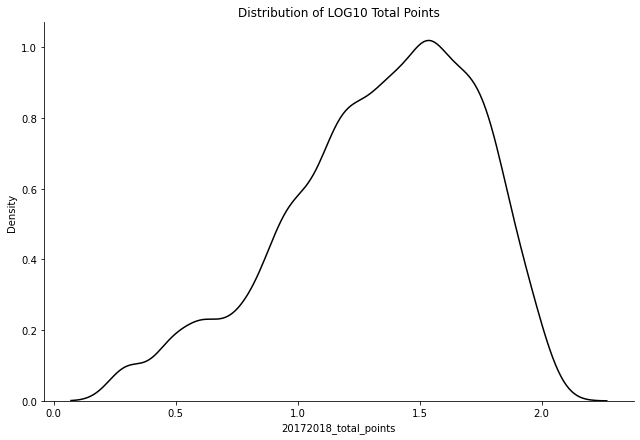

In [176]:
plt.figure(figsize=(10,6))
sns.displot(stats_DF, x = np.log10(stats_DF['20172018_total_points'] + 1), kind = 'kde', height=6, aspect=1.5, color='black')
plt.title('Distribution of LOG10 Total Points')
plt.show()

<Figure size 720x432 with 0 Axes>

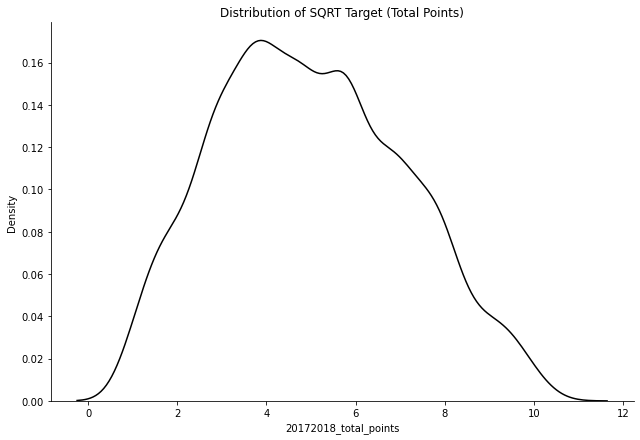

In [177]:
plt.figure(figsize=(10,6))
sns.displot(stats_DF, x = np.sqrt(stats_DF['20172018_total_points']), kind = 'kde', height=6, aspect=1.5, color='black')
plt.title('Distribution of SQRT Target (Total Points)')
plt.show()

In [181]:
print("Normal Skew: ", stats_DF['20172018_total_points'].skew(), ' = Right Skew')
print("LOG10 Skew: ", np.log10(stats_DF['20172018_total_points']+1).skew(), ' = Left Skew')
print("SQRT Skew: ", np.sqrt(stats_DF['20172018_total_points']).skew(), ' = ~Normal Distribution')

Normal Skew:  0.9713956220998539  = Right Skew
LOG10 Skew:  -0.5855823850138437  = Left Skew
SQRT Skew:  0.22056941132611227  = ~Normal Distribution


<Figure size 720x432 with 0 Axes>

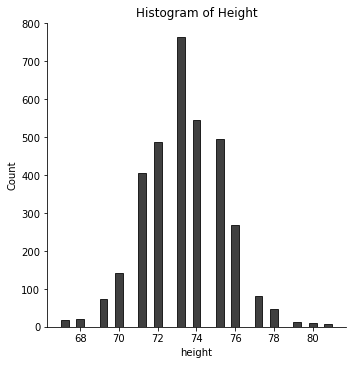

In [182]:
plt.figure(figsize=(10,6))
sns.displot(stats_DF, x = (stats_DF['height']), color='black')
plt.title('Histogram of Height')
plt.show()

<Figure size 720x432 with 0 Axes>

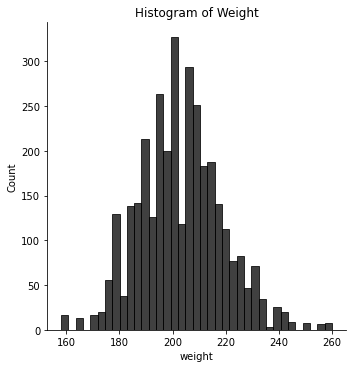

In [183]:
plt.figure(figsize=(10,6))
sns.displot(stats_DF, x = (stats_DF['weight']), color='black')
plt.title('Histogram of Weight')
plt.show()

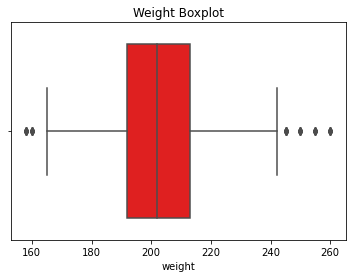

In [184]:
plt.figure()
sns.boxplot(x = stats_DF['weight'], color='red')
plt.title('Weight Boxplot')
plt.show()

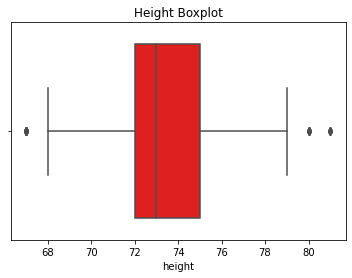

In [185]:
plt.figure()
sns.boxplot(x = stats_DF['height'], color='red')
plt.title('Height Boxplot')
plt.show()

20142015_goals


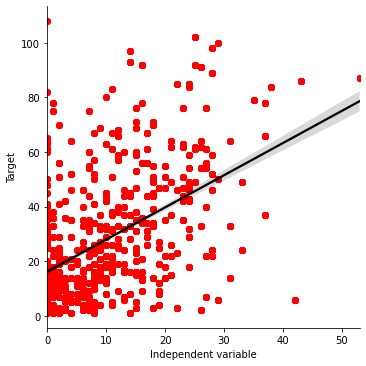

20142015_shots


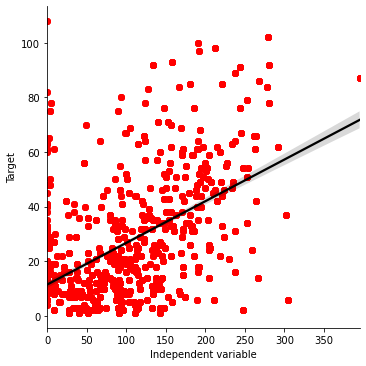

20142015_penalty_min


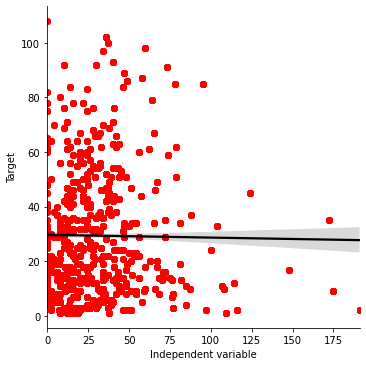

20142015_shotPct


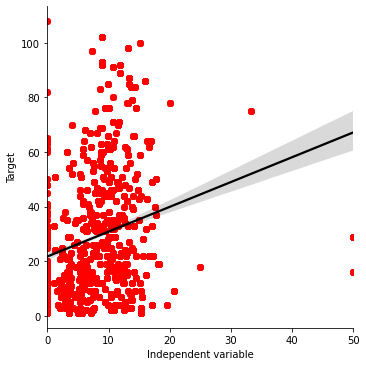

20142015_plus_minus


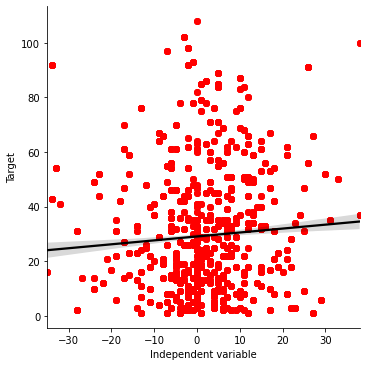

20142015_total_points


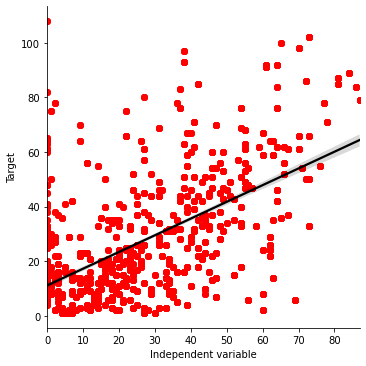

20152016_assists


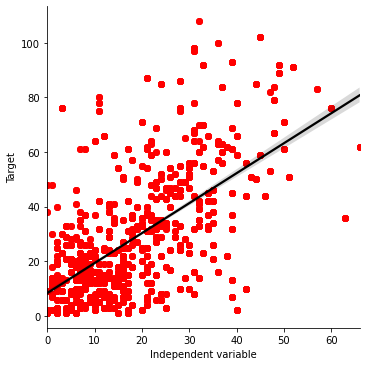

20152016_games


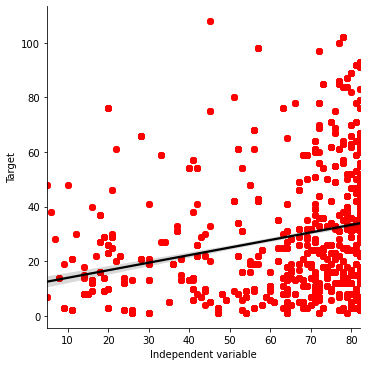

20152016_hits


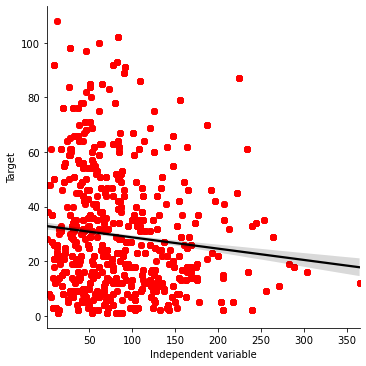

20152016_blocked


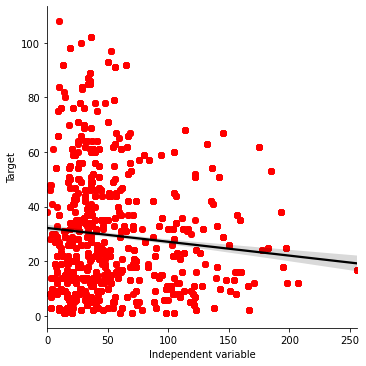

20152016_shifts


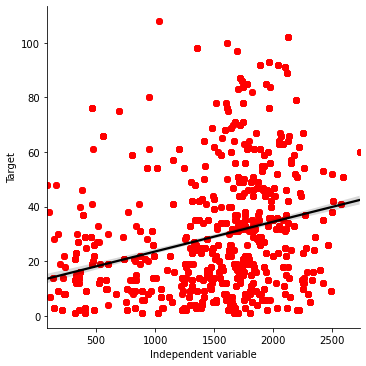

In [210]:
# Randomly checking columns for a linear relationship, some look good while others do not.
for i in range(5, 26, 2):
    print(stats_DF.columns[i])
    sns.lmplot(x=stats_DF.columns[i], y="20172018_total_points", data=stats_DF, line_kws={'color': 'black'}, 
          scatter_kws={'color': 'red'})
    plt.ylabel('Target')
    plt.xlabel('Independent variable')
    plt.show()

<Figure size 720x576 with 0 Axes>

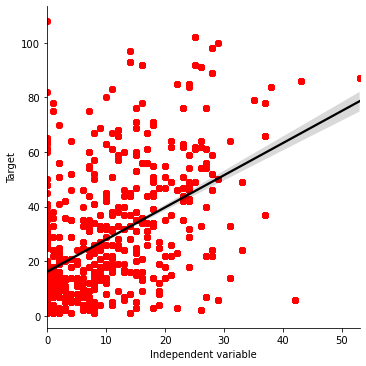

In [186]:
plt.figure(figsize=(10, 8))
sns.lmplot(x="20142015_goals", y="20172018_total_points", data=stats_DF, line_kws={'color': 'black'}, 
          scatter_kws={'color': 'red'})
plt.ylabel('Target')
plt.xlabel('Independent variable')
plt.show()

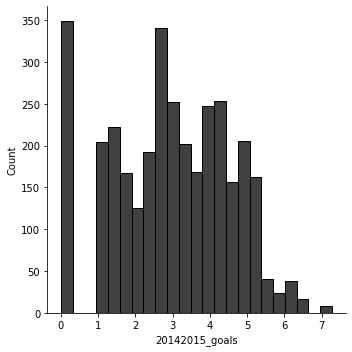

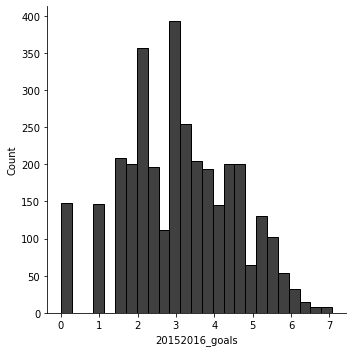

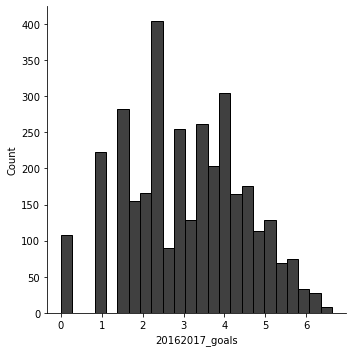

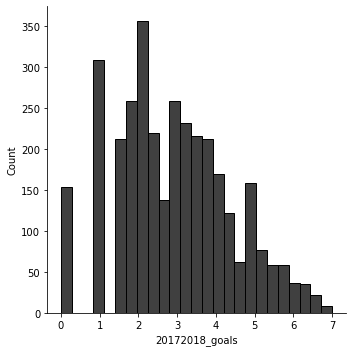

In [195]:
# Judging off our target variable total points, it propably makes sense to transform all of our different goals,
# assists, and total points to better match a normal distribution. Checking this assumption with a histogram plot
# for all goal variables, This assumption is made due to the fact that total points equals goals + assists.
for year in years_list[4:]:
    sns.displot(np.sqrt(stats_DF[year + '_goals']), color='black')

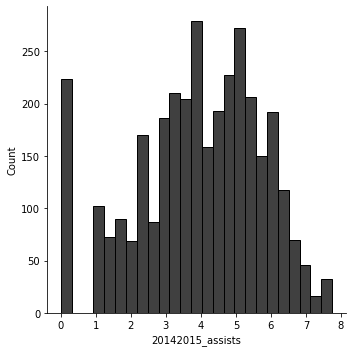

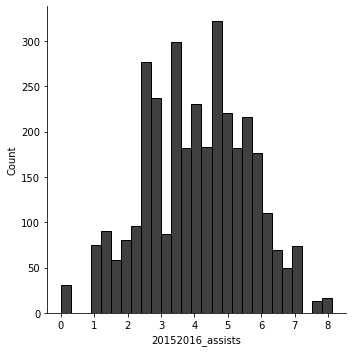

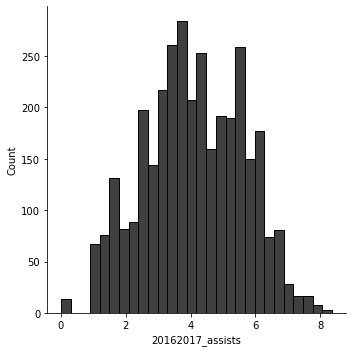

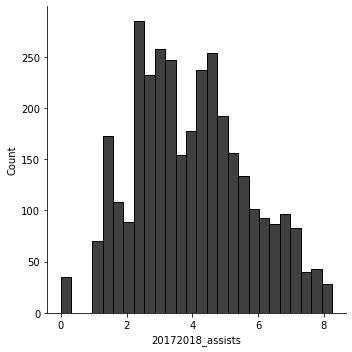

In [196]:
# Checking the square root transformation for assists by year
for year in years_list[4:]:
    sns.displot(np.sqrt(stats_DF[year + '_assists']), color='black')

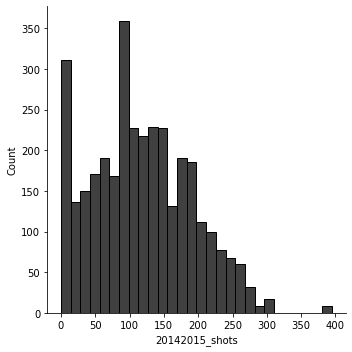

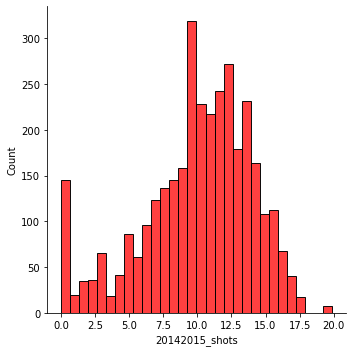

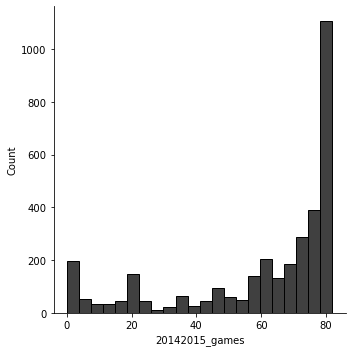

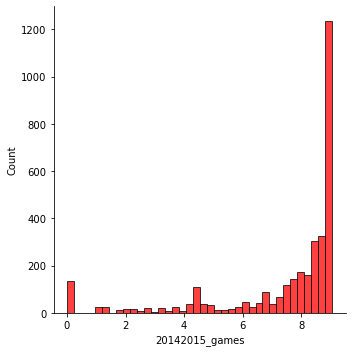

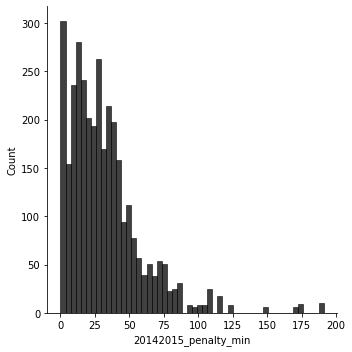

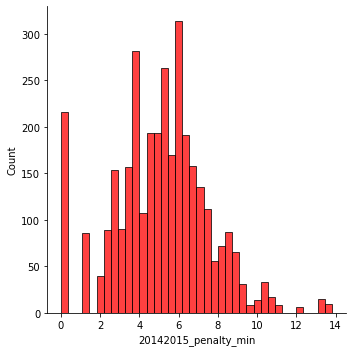

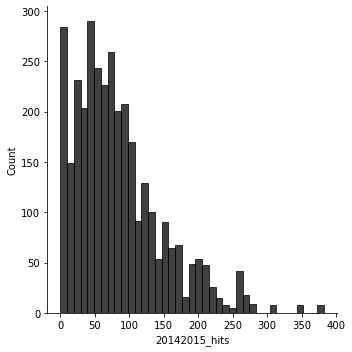

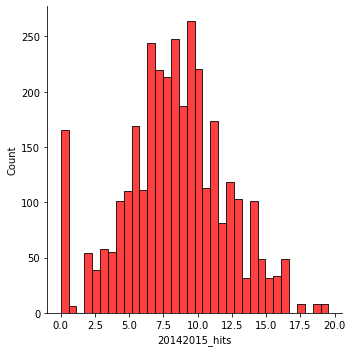

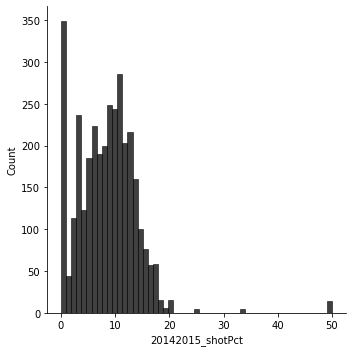

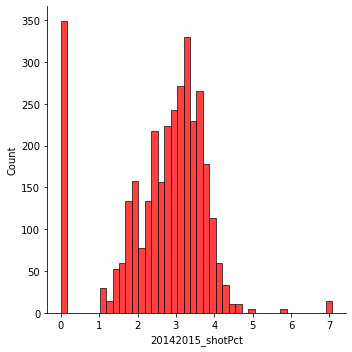

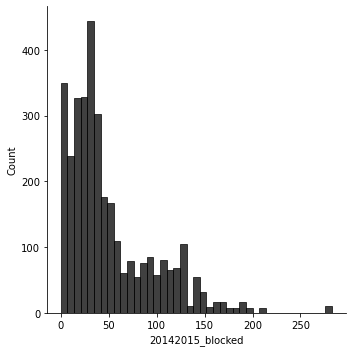

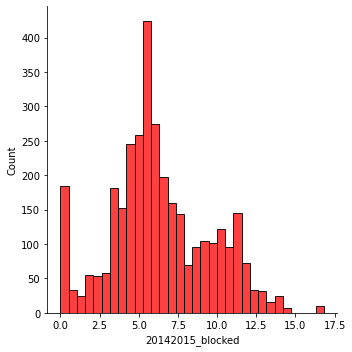

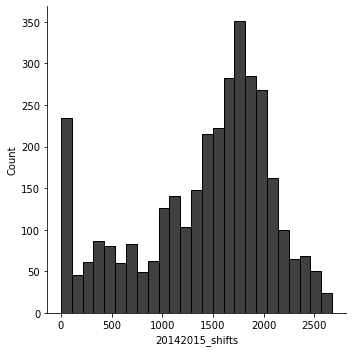

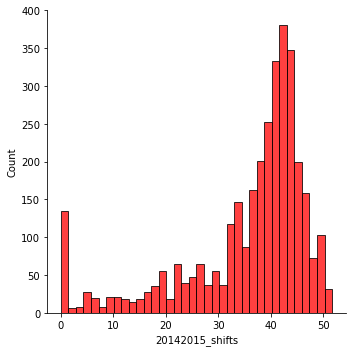

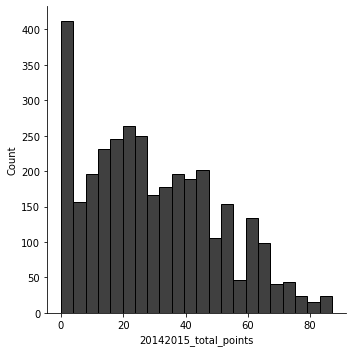

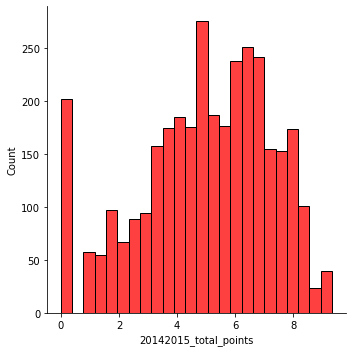

In [197]:
for c in stats_DF.columns[7:16]:
    if c != '20142015_plus_minus':
        sns.displot(stats_DF[c], color='black')
        sns.displot(np.sqrt(stats_DF[c]), color='red')

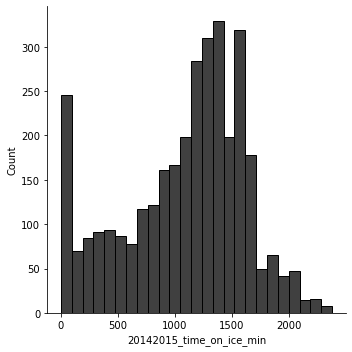

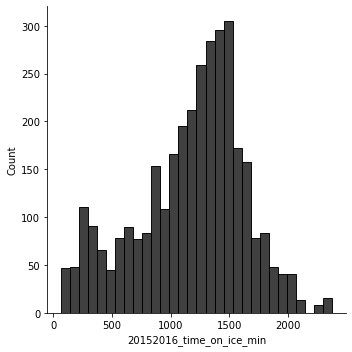

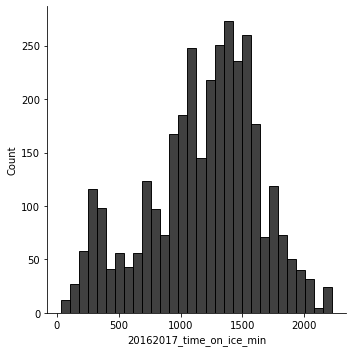

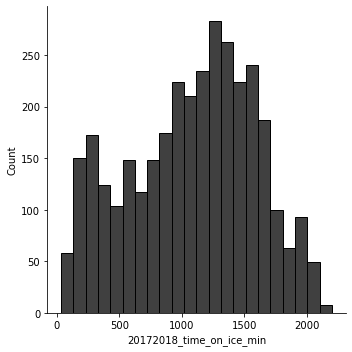

In [198]:
for year in years_list[4:]:
    sns.displot((stats_DF[year + '_time_on_ice_min']), color='black')

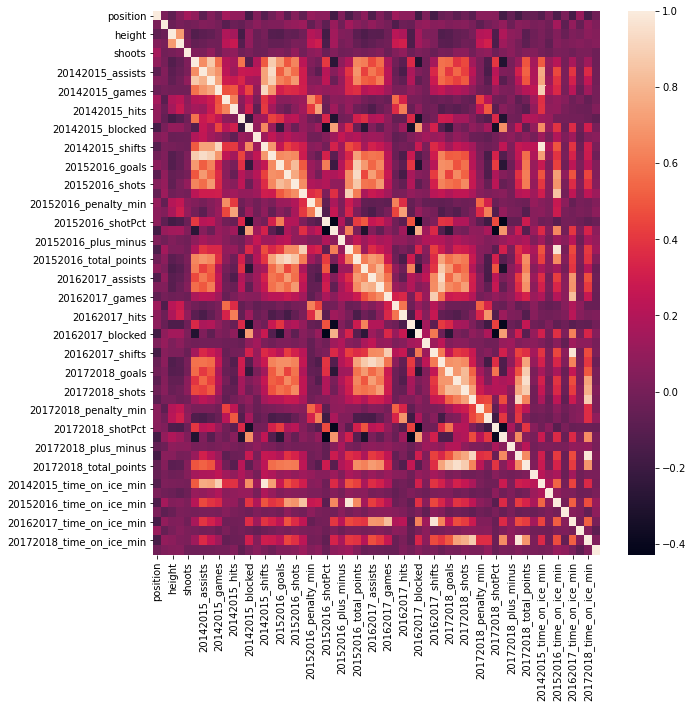

In [199]:
plt.figure(figsize=(10, 10))
sns.heatmap(stats_DF.corr())
plt.show()

In [353]:
final_data = stats_DF

In [354]:
final_data.to_pickle("./final_data.pkl")

In [211]:
features = stats_DF.drop(columns = ['20172018_total_points'])
target = stats_DF['20172018_total_points'].values

features = features.reset_index().drop(columns = ['index'])

In [212]:
for c in features.columns[5:48]:
    if c.find('_plus_minus') == -1:
        features[c] = np.sqrt(features[c])
        
target = np.sqrt(target)

In [213]:
scaler = MinMaxScaler()

In [214]:
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(np.array(target).reshape(-1,1))

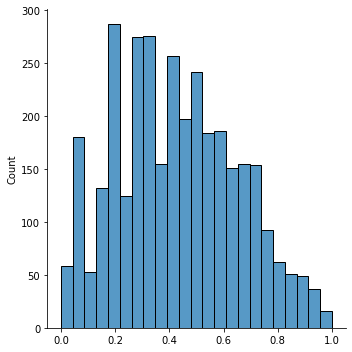

In [303]:
sns.displot(target_scaled, legend = False)

In [216]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=.3)

In [217]:
lin_reg = LinearRegression()
ridge_reg = Ridge()
dec_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()

In [218]:
lin_reg.fit(X_train, y_train)
lin_pred = lin_reg.predict(X_test)

In [219]:
lin_pred = np.square(scaler.inverse_transform(lin_pred))
y_test_revert = np.square(scaler.inverse_transform(y_test))

In [220]:
print("Coefficients: \n", lin_reg.intercept_)
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test_revert, lin_pred)))
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test_revert, lin_pred))

Coefficients: 
 [-0.0499543]
Root Mean Squared Error: 
 0.9312294563220294
Mean Absolute Error: 
 0.6366932852578333


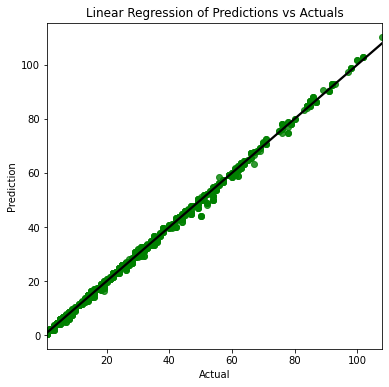

In [274]:
plt.figure(figsize=(6,6))
sns.regplot(x = y_test_revert[:, 0], y = lin_pred[:, 0], scatter_kws = {'color': 'green'}, line_kws = {'color': 'black'})
plt.title('Linear Regression of Predictions vs Actuals')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

Text(0.5, 1.0, 'Residuals of Linear Regression Model')

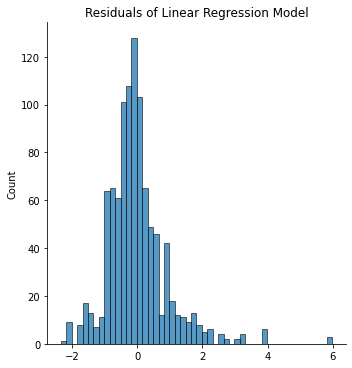

In [302]:
sns.displot(y_test_revert - lin_pred, legend = False)
plt.title('Residuals of Linear Regression Model')

In [265]:
importance = lin_reg.coef_

In [269]:
for x, y in enumerate(importance[0]):
    print('Feature: %0d,____Score: %f,____Column: %0s' % (x, y, features.columns[x]))

Feature: 0,____Score: -0.001353,____Column: position
Feature: 1,____Score: 0.000686,____Column: country
Feature: 2,____Score: 0.004279,____Column: height
Feature: 3,____Score: -0.011996,____Column: weight
Feature: 4,____Score: -0.001020,____Column: shoots
Feature: 5,____Score: -0.061131,____Column: 20142015_goals
Feature: 6,____Score: -0.119095,____Column: 20142015_assists
Feature: 7,____Score: -0.002129,____Column: 20142015_shots
Feature: 8,____Score: 0.004625,____Column: 20142015_games
Feature: 9,____Score: 0.007062,____Column: 20142015_penalty_min
Feature: 10,____Score: 0.007997,____Column: 20142015_hits
Feature: 11,____Score: -0.012166,____Column: 20142015_shotPct
Feature: 12,____Score: -0.002593,____Column: 20142015_blocked
Feature: 13,____Score: -0.006462,____Column: 20142015_plus_minus
Feature: 14,____Score: -0.024427,____Column: 20142015_shifts
Feature: 15,____Score: 0.177070,____Column: 20142015_total_points
Feature: 16,____Score: -0.007985,____Column: 20152016_goals
Feature: 

In [293]:
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

In [294]:
ridge_pred = np.square(scaler.inverse_transform(ridge_pred))
y_test_revert = np.square(scaler.inverse_transform(y_test))

In [296]:
print("Intercept: \n", ridge_reg.intercept_)
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test_revert, ridge_pred)))
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test_revert, ridge_pred))

Intercept: 
 [-0.06900332]
Root Mean Squared Error: 
 1.0972450660111823
Mean Absolute Error: 
 0.7708808530848132


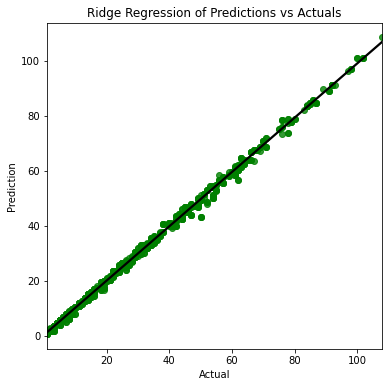

In [275]:
plt.figure(figsize=(6,6))
sns.regplot(x = y_test_revert[:, 0], y = ridge_pred[:, 0], scatter_kws = {'color': 'green'}, line_kws = {'color': 'black'})
plt.title('Ridge Regression of Predictions vs Actuals')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

Text(0.5, 1.0, 'Residuals of Ridge Regression Model')

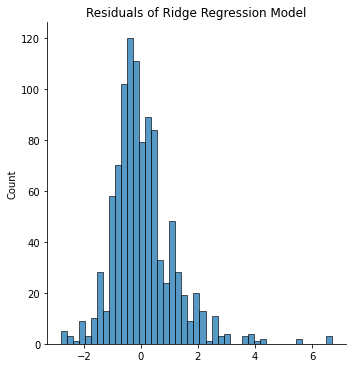

In [305]:
sns.displot(y_test_revert - ridge_pred, legend = False)
plt.title('Residuals of Ridge Regression Model')

In [341]:
features = stats_DF.drop(columns = ['20172018_total_points'])
target = stats_DF['20172018_total_points'].values

features = features.reset_index().drop(columns = ['index'])

In [342]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)

In [308]:
dec_reg.fit(X_train, y_train)
dec_pred = dec_reg.predict(X_test)

In [309]:
dec_reg.score(X_train, y_train)

1.0

In [310]:
dec_reg.score(X_test, y_test)

0.9999756252033087

In [320]:
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test, dec_pred))
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test, dec_pred)))

Mean Absolute Error: 
 0.005923000987166831
Root Mean Squared Error: 
 0.10883934019615178


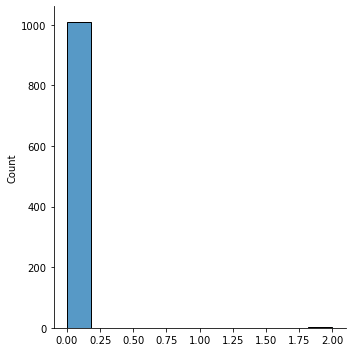

In [321]:
sns.displot(y_test - dec_pred)

In [322]:
tree_depth = [i for i in range(1, 30)]

In [323]:
train_scores = []
test_scores = []
train_rmse_scores = []
test_rmse_scores = []
for i in tree_depth:
    model = DecisionTreeRegressor(max_depth=i)
    
    model.fit(X_train, y_train)
    
    train_y = model.predict(X_train)
    train_mae = metrics.mean_absolute_error(y_train, train_y)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_y))
    train_scores.append(train_mae)
    train_rmse_scores.append(train_rmse)
    
    test_y = model.predict(X_test)
    test_mae = metrics.mean_absolute_error(y_test, test_y)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_y))
    test_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print('>%d, train: %.3f, test: %.3f' % (i, train_rmse, test_rmse))

>1, train: 13.610, test: 13.425
>2, train: 8.581, test: 8.983
>3, train: 5.828, test: 6.366
>4, train: 3.994, test: 4.492
>5, train: 2.767, test: 3.045
>6, train: 1.884, test: 2.076
>7, train: 1.065, test: 1.300
>8, train: 0.571, test: 0.762
>9, train: 0.250, test: 0.371
>10, train: 0.092, test: 0.185
>11, train: 0.000, test: 0.000
>12, train: 0.000, test: 0.163
>13, train: 0.000, test: 0.000
>14, train: 0.000, test: 0.163
>15, train: 0.000, test: 0.000
>16, train: 0.000, test: 0.163
>17, train: 0.000, test: 0.000
>18, train: 0.000, test: 0.163
>19, train: 0.000, test: 0.109
>20, train: 0.000, test: 0.000
>21, train: 0.000, test: 0.000
>22, train: 0.000, test: 0.000
>23, train: 0.000, test: 0.000
>24, train: 0.000, test: 0.109
>25, train: 0.000, test: 0.163
>26, train: 0.000, test: 0.109
>27, train: 0.000, test: 0.109
>28, train: 0.000, test: 0.163
>29, train: 0.000, test: 0.000


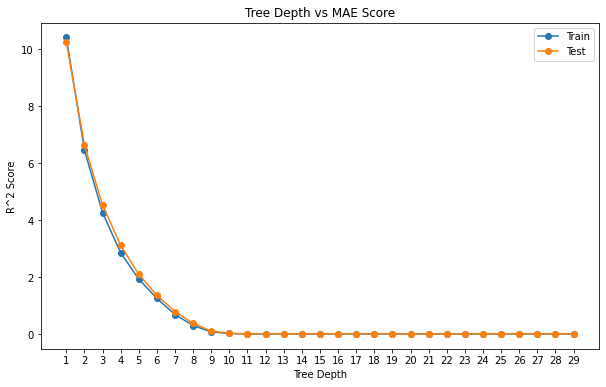

In [324]:
plt.figure(figsize=(10,6))
plt.plot(tree_depth, train_scores, '-o', label='Train')
plt.plot(tree_depth, test_scores, '-o', label='Test')
plt.legend()
plt.title('Tree Depth vs MAE Score')
plt.xlabel('Tree Depth')
plt.ylabel('R^2 Score')
plt.xticks(tree_depth)
plt.show()

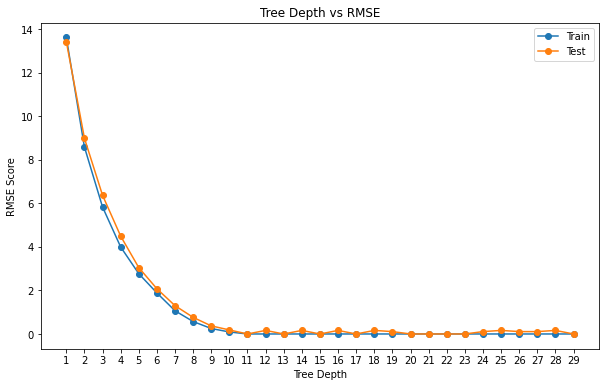

In [325]:
plt.figure(figsize=(10,6))
plt.plot(tree_depth, train_rmse_scores, '-o', label='Train')
plt.plot(tree_depth, test_rmse_scores, '-o', label='Test')
plt.legend()
plt.title('Tree Depth vs RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE Score')
plt.xticks(tree_depth)
plt.show()

In [326]:
dec_reg_tuned = DecisionTreeRegressor(max_depth=3)
dec_reg_tuned.fit(X_train, y_train)
dec_reg_tuned_pred = dec_reg_tuned.predict(X_test)

In [327]:
print(dec_reg_tuned.score(X_train, y_train))
print(dec_reg_tuned.score(X_test, y_test))
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test, dec_reg_tuned_pred))
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test, dec_reg_tuned_pred)))

0.9351664182089603
0.9166192333100217
Mean Absolute Error: 
 4.528113694740539
Root Mean Squared Error: 
 6.365731864527786


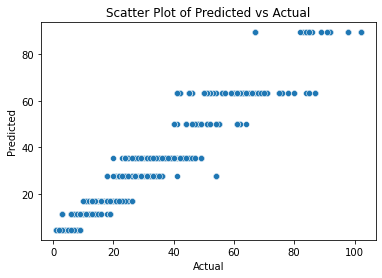

In [328]:
sns.scatterplot(x = y_test, y = dec_reg_tuned_pred)
plt.title('Scatter Plot of Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

Text(0.5, 1.0, 'Residual Plot of Decision Tree')

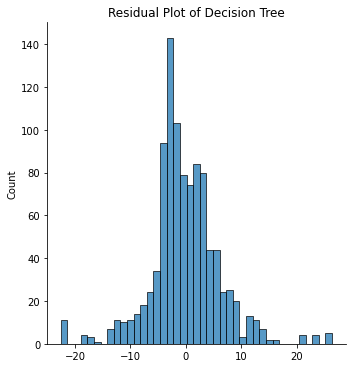

In [329]:
sns.displot(y_test - dec_reg_tuned_pred)
plt.title('Residual Plot of Decision Tree')

In [330]:
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

In [331]:
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test, rf_pred))
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test, rf_pred)))

Mean Absolute Error: 
 0.07908193484698911
Root Mean Squared Error: 
 0.2441349536977021


In [332]:
rf_reg.score(X_train, y_train)

0.9999739704442612

In [333]:
rf_reg.score(X_test, y_test)

0.9998773608510512

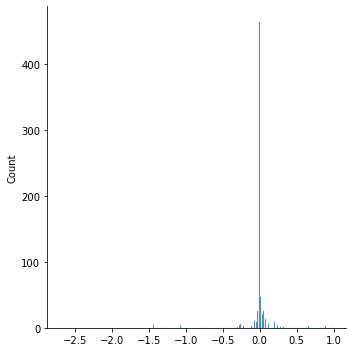

In [334]:
sns.displot(y_test - rf_pred)

In [338]:
train_scores = []
test_scores = []
train_rmse_scores = []
test_rmse_scores = []
for i in tree_depth:
    model = RandomForestRegressor(max_depth=i)
    
    model.fit(X_train, y_train)
    
    train_y = model.predict(X_train)
    train_mae = metrics.mean_absolute_error(y_train, train_y)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_y))
    train_scores.append(train_mae)
    train_rmse_scores.append(train_rmse)
    
    test_y = model.predict(X_test)
    test_mae = metrics.mean_absolute_error(y_test, test_y)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_y))
    test_scores.append(test_mae)
    test_rmse_scores.append(test_rmse)
    
    print('>%d, train: %.3f, test: %.3f' % (i, train_rmse, test_rmse))

>1, train: 12.433, test: 12.233
>2, train: 7.621, test: 7.974
>3, train: 4.370, test: 4.913
>4, train: 3.058, test: 3.487
>5, train: 1.865, test: 2.126
>6, train: 1.160, test: 1.404
>7, train: 0.666, test: 0.876
>8, train: 0.356, test: 0.521
>9, train: 0.202, test: 0.324
>10, train: 0.130, test: 0.262
>11, train: 0.111, test: 0.205
>12, train: 0.095, test: 0.192
>13, train: 0.116, test: 0.235
>14, train: 0.114, test: 0.250
>15, train: 0.102, test: 0.218
>16, train: 0.103, test: 0.203
>17, train: 0.101, test: 0.193
>18, train: 0.123, test: 0.262
>19, train: 0.117, test: 0.241
>20, train: 0.107, test: 0.227
>21, train: 0.110, test: 0.204
>22, train: 0.107, test: 0.220
>23, train: 0.119, test: 0.246
>24, train: 0.114, test: 0.243
>25, train: 0.105, test: 0.207
>26, train: 0.109, test: 0.223
>27, train: 0.115, test: 0.229
>28, train: 0.128, test: 0.264
>29, train: 0.112, test: 0.235


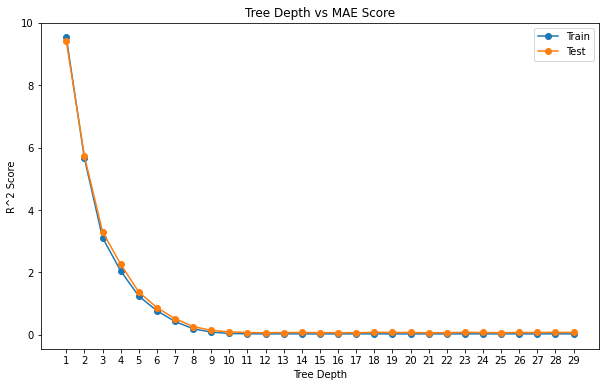

In [344]:
plt.figure(figsize=(10,6))
plt.plot(tree_depth, train_scores, '-o', label='Train')
plt.plot(tree_depth, test_scores, '-o', label='Test')
plt.legend()
plt.title('Tree Depth vs MAE Score')
plt.xlabel('Tree Depth')
plt.ylabel('R^2 Score')
plt.xticks(tree_depth)
plt.show()

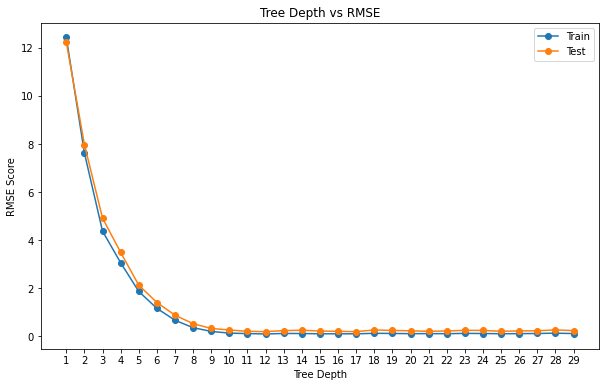

In [345]:
plt.figure(figsize=(10,6))
plt.plot(tree_depth, train_rmse_scores, '-o', label='Train')
plt.plot(tree_depth, test_rmse_scores, '-o', label='Test')
plt.legend()
plt.title('Tree Depth vs RMSE')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE Score')
plt.xticks(tree_depth)
plt.show()

In [346]:
rf_reg_tuned = RandomForestRegressor(max_depth=4)
rf_reg_tuned.fit(X_train, y_train)
rf_reg_tuned_pred = rf_reg_tuned.predict(X_test)

In [347]:
print(rf_reg_tuned.score(X_train, y_train))
print(rf_reg_tuned.score(X_test, y_test))
print("Mean Absolute Error: \n", metrics.mean_absolute_error(y_test, rf_reg_tuned_pred))
print("Root Mean Squared Error: \n", np.sqrt(mean_squared_error(y_test, rf_reg_tuned_pred)))

0.9852217146023151
0.9850975091524399
Mean Absolute Error: 
 1.9461265119096607
Root Mean Squared Error: 
 2.771472991381582


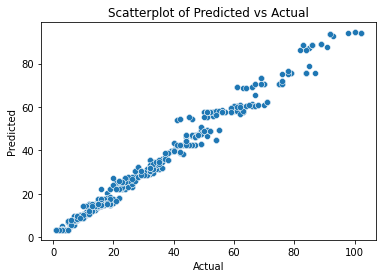

In [349]:
sns.scatterplot(x = y_test, y = rf_reg_tuned_pred)
plt.title('Scatterplot of Predicted vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

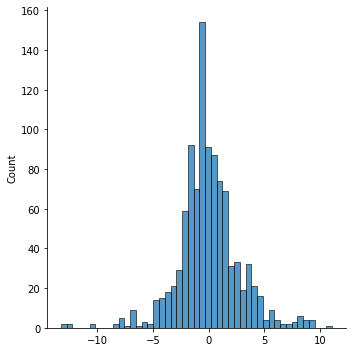

In [350]:
sns.displot(y_test - rf_reg_tuned_pred)